In [12]:
#!pip install tscv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

- Collect average transaction size for a credit card
- Average longitude and latitude of transactions
- Average time of transaction
- 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
# Original files we used

folder_location = '/content/gdrive/MyDrive/Colab Notebooks/DS4400: ML Project/' 
training = pd.read_csv(folder_location + 'fraudTrain.csv')  
testing = pd.read_csv(folder_location + 'fraudTest.csv')

# Files we used that have aggregations applied to help speed up process of getting engineered features.
X_train = pd.read_csv(folder_location + 'X_train_eng.csv').drop(["Unnamed: 0"], axis=1)
y_train = pd.read_csv(folder_location + 'y_train.csv').drop(["Unnamed: 0"], axis=1)  
X_test = pd.read_csv(folder_location + 'X_test_agg.csv').drop(["Unnamed: 0", "is_fraud"], axis=1)  
y_test = pd.read_csv(folder_location + 'y_test.csv').drop(["Unnamed: 0"], axis=1)   


In [17]:
X_train.head()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,hour,day,month,dob_year,is_man,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,amt_count,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num
0,4.97,36.0788,-81.1781,3495.0,36.011293,-82.048315,0,0,1,1,1988,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107.23,48.8878,-118.2105,149.0,49.159047,-118.186462,0,0,1,1,1978,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,220.11,42.1808,-112.2620,4154.0,43.150704,-112.154481,0,0,1,1,1962,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45.00,46.2306,-112.1138,1939.0,47.034331,-112.561071,0,0,1,1,1967,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.96,38.4207,-79.4629,99.0,38.674999,-78.632459,0,0,1,1,1986,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


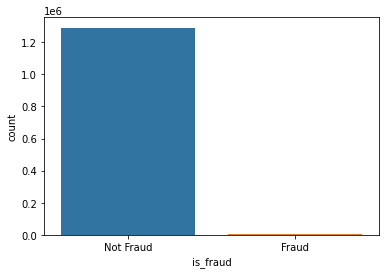

In [5]:
# visualize the target variable - clearly our data is highly imbalanced and something must be done to fix this issue
g = sns.countplot(training['is_fraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

Text(0.5, 1.0, 'Heatmap of Feature Correlation')

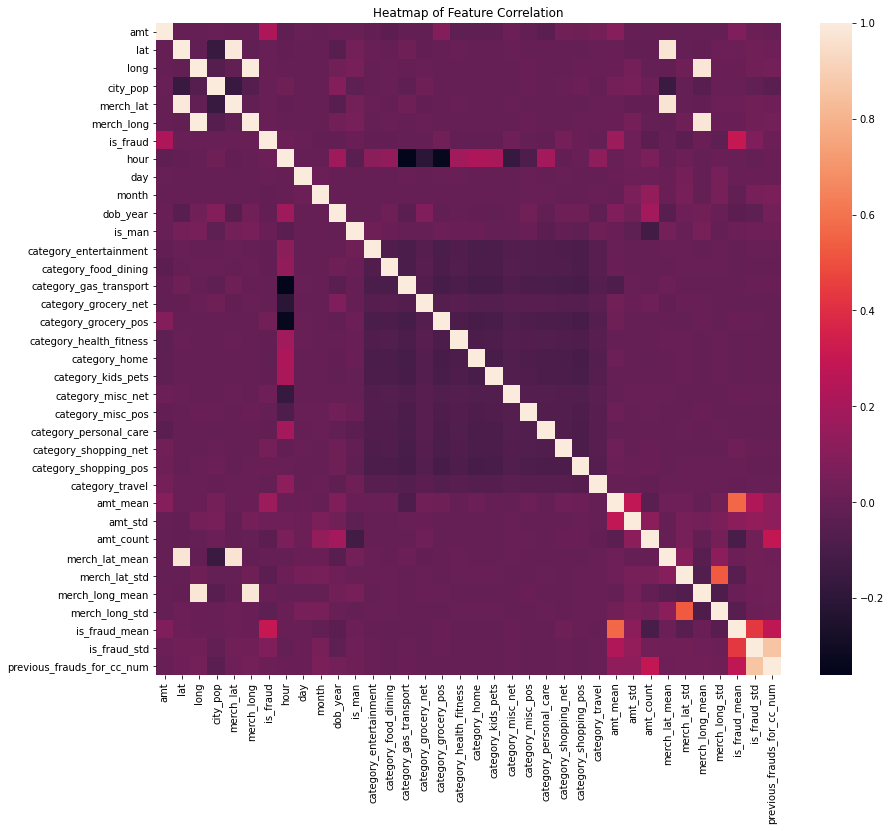

In [6]:
corr = X_train.corr()
plt.figure(figsize=(14,12))
heat = sns.heatmap(data=corr)
plt.title("Heatmap of Feature Correlation")


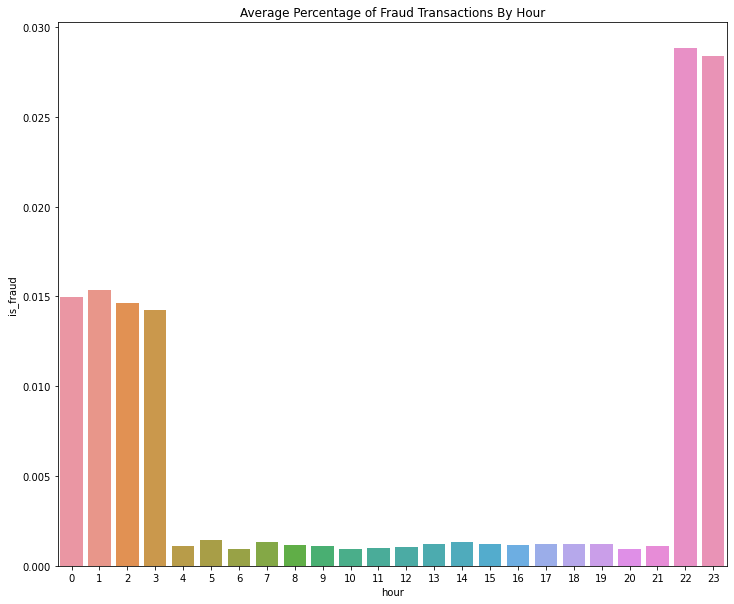

In [7]:
is_fraud_by_hour = X_train[['hour', "is_fraud"]]
is_fraud_by_hour_agg = is_fraud_by_hour.groupby(["hour"]).agg("mean")
plt.figure(figsize=(12,10))
plt.title("Average Percentage of Fraud Transactions By Hour")
sns.barplot(x=is_fraud_by_hour_agg.index, y=is_fraud_by_hour_agg['is_fraud'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


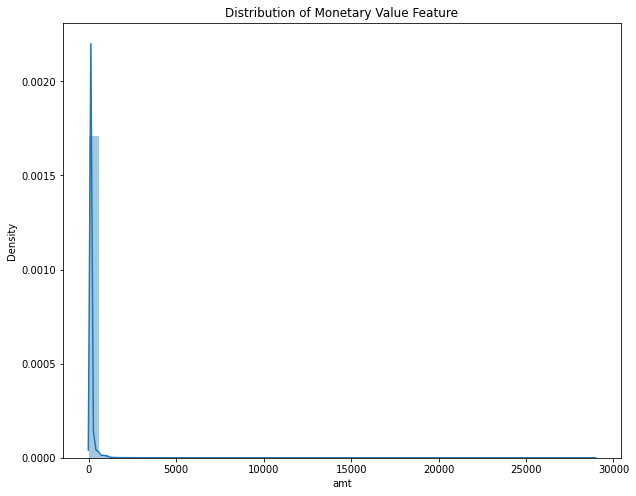

In [8]:
plt.figure(figsize=(10,8))
plt.title("Distribution of Monetary Value Feature")
sns.distplot(X_train['amt'])

In [13]:
from time import mktime
from sklearn.preprocessing import MinMaxScaler

## All functions that are used to scale features, engineer features, drop unnecessary columns, and create aggregated features.

def normalize_features(X_train, X_test):
  scaler = MinMaxScaler()
  X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
  X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)
  return X_train_scaled, X_test_scaled

def engineer_datetime(df):
  df["datetime"] = df["trans_date_trans_time"].apply(pd.to_datetime)
  df["hour"] = df["datetime"].dt.hour
  df["day"] = df["datetime"].dt.day
  df["month"] = df["datetime"].dt.month
  df["unix_purchase_time"] = df["datetime"].apply(lambda dt: mktime(dt.timetuple()))
  dob_dt = df["dob"].apply(pd.to_datetime)
  dob_year = dob_dt.dt.year 
  df["dob_year"] = dob_year
  df["unix_dob"] = dob_dt.apply(lambda dt: mktime(dt.timetuple()))
  df = df.drop(["trans_date_trans_time", "dob"], axis=1)
  return df

def engineer_features(df):
  df = engineer_datetime(df)
  df = df.drop(["state", "city", "Unnamed: 0", "merchant", "first", "last", "street", "zip", "job", "unix_time"], axis=1)
  df["is_man"] = df["gender"].apply(lambda x: 0 if x == "F" else 1)
  df = df.drop("gender", axis=1)
  df.reset_index(inplace=True)
  #df = pd.DataFrame(df, dtype={'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  df = df.astype({'amt': float, 'lat': float, 'long': float, 'city_pop': float, 'merch_lat': float, 'merch_long': float})
  obj_df = df.select_dtypes(include=['object']).copy()
  obj_df_encoded = pd.get_dummies(obj_df, columns=["category"], prefix=["category"])
  df = df.drop(["category"], axis=1)
  obj_df_encoded.reset_index(inplace=True)
  df = pd.concat([df,obj_df_encoded],axis=1).drop("index", axis=1)
  df = df.loc[:,~df.columns.duplicated()]
  means = df.apply(concat_averages, frame=df, axis=1)
  df = df.merge(means, left_on='trans_num', right_on='trans_num')
  df.drop(['datetime', 'cc_num', 'trans_num'], axis=1, inplace=True)
  return df


def f(x):
    d = {}
    d['amt_mean'] = x['amt'].mean()
    d['amt_std'] = x['amt'].std()
    d['amt_count'] = x['amt'].count()
    d['merch_lat_mean'] = x['merch_lat'].mean()
    d['merch_lat_std'] = x['merch_lat'].std()
    d['merch_long_mean'] = x['merch_long'].mean()
    d['merch_long_std'] = x['merch_long'].std()
    d['is_fraud_mean'] = x['is_fraud'].mean()
    d['is_fraud_std'] = x['is_fraud'].std()
    d['previous_frauds_for_cc_num'] = d['amt_count'] * d['is_fraud_mean']
    return pd.Series(d, index=['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num'])

def concat_averages(row, frame):
  date = row['datetime']
  cc_num = row['cc_num']
  frame_before_date = frame.loc[ (frame["cc_num"] == cc_num) & (frame['datetime'] < date)].copy()
  frame_before_date.drop(columns=['city_pop', 'lat', 'long'], inplace=True)
  cc_averages = frame_before_date.groupby("cc_num").apply(f)
  cc_averages = cc_averages.fillna(0)
  indices = ['amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  if len(cc_averages.values) == 0:
    zeros = np.zeros(len(indices))
    series = pd.Series(zeros, index=indices)
  else:
    series = pd.Series(cc_averages.values[0], index=indices)
  series['trans_num'] = row['trans_num']
  return series



In [10]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Here we attempt to undersample the training data majority class (non-fraud)

y_train = training["is_fraud"]
X_train = training.drop(["is_fraud"], axis = 1)

# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy=.1)

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before undersampling:  Counter({0: 1289169, 1: 7506})
After undersampling:  Counter({0: 75060, 1: 7506})


In [ ]:
# Functions to aggregate columns and add them to a new dataframe based on credit card number. 

def create_aggregated_df_to_apply_to_test(train_df):
  lat_long_df = train_df[['lat', 'long', 'amt_count']]
  lat_long_df_agg = lat_long_df.groupby(['lat', 'long']).agg('max')
  lat_long_df_agg.set_index(['amt_count'], append=True, inplace=True)
  lat_long_df_agg.head()
  indices = ['lat', 'long', 'amt_mean', 'amt_std', 'amt_count', 'merch_lat_mean', 'merch_lat_std', 'merch_long_mean', 'merch_long_std', 'is_fraud_mean', 'is_fraud_std', 'previous_frauds_for_cc_num']
  cc_averages_by_lat = train_df[indices]
  cc_averages_by_lat.set_index(['lat', 'long', 'amt_count'], inplace=True)
  df_with_maxes = pd.merge(lat_long_df_agg, cc_averages_by_lat, left_index=True, right_index=True, how="inner")
  df_with_maxes.reset_index(level='amt_count', inplace=True)
  return df_with_maxes

agg_df_to_apply_to_test = create_aggregated_df_to_apply_to_test(X_train_under_df)


def map_aggregations(row, frame):
  lat = row['lat']
  long = row['long']
  if (lat, long) not in frame.index:
    return row
  else:
    frame_row = frame.loc[(lat, long)]
    if row['amt_count'] == 0:
      row['amt_mean'] = frame_row['amt_mean']
      row['amt_std'] = frame_row['amt_std']
      row['amt_count'] = frame_row['amt_count']
      row['merch_lat_mean'] = frame_row['merch_lat_mean']
      row['merch_lat_std'] = frame_row['merch_lat_std']
      row['merch_long_mean'] = frame_row['merch_long_mean']
      row['merch_long_std'] = frame_row['merch_long_std']
      row['is_fraud_mean'] = frame_row['is_fraud_mean']
      row['is_fraud_std'] = frame_row['is_fraud_std']
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num']
      return row
    else:
      test_count = row['amt_count']
      frame_row_count = frame_row['amt_count']

      row['amt_mean'] = combine_means(row['amt_mean'], frame_row['amt_mean'], test_count, frame_row_count)
      row['amt_std'] = combine_std(row['amt_std'], frame_row['amt_std'], test_count, frame_row_count)
      row['amt_count'] = test_count + frame_row_count
      row['merch_lat_mean'] = combine_means(row['merch_lat_mean'], frame_row['merch_lat_mean'], test_count, frame_row_count)
      row['merch_lat_std'] = combine_std(row['merch_lat_std'], frame_row['merch_lat_std'], test_count, frame_row_count)
      row['merch_long_mean'] = combine_means(row['merch_long_mean'], frame_row['merch_long_mean'], test_count, frame_row_count)
      row['merch_long_std'] = combine_std(row['merch_long_std'], frame_row['merch_long_std'], test_count, frame_row_count)
      row['is_fraud_mean'] = combine_means(row['is_fraud_mean'], frame_row['is_fraud_mean'], test_count, frame_row_count)
      row['is_fraud_std'] = combine_std(row['is_fraud_std'], frame_row['is_fraud_std'], test_count, frame_row_count)
      row['previous_frauds_for_cc_num'] = frame_row['previous_frauds_for_cc_num'] + row['previous_frauds_for_cc_num']
      return row

def combine_means(mean1, mean2, n1, n2):
  return (mean1 * n1 + mean2 * n2) / (n1 + n2)

def combine_std(std1, std2, n1, n2):
  var1 = (std1 ** 2) / n1
  var2 = (std2 ** 2) / n2
  return np.sqrt((var1 + var2) / 2)   

def apply_aggregation_df_to_test(test_df, agg_df):
  return test_df.apply(map_aggregations, frame=agg_df, axis=1)

## X_test_df_agg = apply_aggregation_df_to_test(X_test_df, agg_df_to_apply_to_test)


In [18]:
# Creating additional dataframe columns to deal with cyclical features such as hour and month and to get more aggregating columns

X_train['hr_sin'] = np.sin(X_train['hour']*(2.*np.pi/24))
X_train['hr_cos'] = np.cos(X_train['hour']*(2.*np.pi/24))
X_train['mnth_sin'] = np.sin((X_train['month']-1)*(2.*np.pi/12))
X_train['mnth_cos'] = np.cos((X_train['month']-1)*(2.*np.pi/12))

X_test['hr_sin'] = np.sin(X_test['hour']*(2.*np.pi/24))
X_test['hr_cos'] = np.cos(X_test['hour']*(2.*np.pi/24))
X_test['mnth_sin'] = np.sin((X_test['month']-1)*(2.*np.pi/12))
X_test['mnth_cos'] = np.cos((X_test['month']-1)*(2.*np.pi/12))

X_train.drop(['is_fraud'], axis=1, inplace=True)
X_train["amt_difference"] = (X_train["amt_mean"] - X_train["amt"]) #/ X_train["amt_std"]
X_train["lat_difference"] = (X_train["merch_lat_mean"] - X_train["merch_lat"]) #/ X_train["merch_lat_std"]
X_train["merch_long_difference"] = (X_train["merch_long_mean"] - X_train["merch_long"]) #/ X_train["merch_long_std"]
X_train = X_train.drop(["is_man", "city_pop", "dob_year", "amt_count", 'month', 'hour'], axis=1)

X_test["amt_difference"] = (X_test["amt_mean"] - X_test["amt"]) #/ X_test["amt_std"]
X_test["lat_difference"] = (X_test["merch_lat_mean"] - X_test["merch_lat"]) #/ X_test["merch_lat_std"]
X_test["merch_long_difference"] = (X_test["merch_long_mean"] - X_test["merch_long"]) #/ X_test["merch_long_std"]
X_test = X_test.drop(["is_man", "city_pop", "dob_year", "amt_count", 'month', 'hour'], axis=1)

In [19]:
# scaling features 

X_train_scaled_df, X_test_scaled_df = normalize_features(X_train, X_test)
#X_train_scaled_df.to_csv(folder_location + "X_train_aggregated_and_scaled.csv")
#X_test_scaled_df.to_csv(folder_location + "X_test_aggregated_and_scaled.csv")

In [20]:
X_train_scaled_df.tail()

,amt,lat,long,merch_lat,merch_long,day,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num,hr_sin,hr_cos,mnth_sin,mnth_cos,amt_difference,lat_difference,merch_long_difference
1296670,0.000503,0.379084,0.544346,0.367421,0.551347,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044096,0.036271,0.561719,0.415637,0.322933,0.435419,0.005952,0.108820,0.473684,0.5,0.0,0.75,0.066987,0.954394,0.984346,0.006415
1296671,0.001751,0.412281,0.902174,0.410026,0.886727,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070625,0.042853,0.584750,0.426240,0.533288,0.439388,0.015094,0.172596,0.421053,0.5,0.0,0.75,0.066987,0.954456,0.976839,0.015377
1296672,0.003625,0.276699,0.612486,0.300969,0.617133,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045493,0.048668,0.489832,0.409624,0.363194,0.439553,0.005317,0.102868,0.578947,0.5,0.0,0.75,0.066987,0.951479,0.961057,0.007183
1296673,0.002553,0.499837,0.646029,0.490098,0.636080,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066802,0.033738,0.645154,0.415553,0.382865,0.442897,0.003955,0.088779,0.421053,0.5,0.0,0.75,0.066987,0.953510,0.979391,0.015390
1296674,0.000114,0.553210,0.530050,0.568003,0.526323,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048113,0.027980,0.682423,0.422747,0.314591,0.446493,0.005295,0.102664,0.421053,0.5,0.0,0.75,0.066987,0.954955,0.960951,0.013017


In [21]:
X_test_scaled_df.head()

,amt,lat,long,merch_lat,merch_long,day,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,amt_mean,amt_std,merch_lat_mean,merch_lat_std,merch_long_mean,merch_long_std,is_fraud_mean,is_fraud_std,previous_frauds_for_cc_num,hr_sin,hr_cos,mnth_sin,mnth_cos,amt_difference,lat_difference,merch_long_difference
0,0.000064,0.298692,0.867121,0.308536,0.857102,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.049069,0.043602,0.505779,0.411062,0.512953,0.445257,0.007692,0.123596,0.631579,0.5,0.0,0.75,0.066987,0.955048,0.971262,0.012851
1,0.000996,0.434867,0.565239,0.421239,0.568699,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.042621,0.061434,0.600080,0.418344,0.335279,0.449110,0.006705,0.115440,0.736842,0.5,0.0,0.75,0.066987,0.953853,0.983884,0.008324
2,0.001391,0.442414,0.942836,0.442800,0.927345,0.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062305,0.045513,0.605235,0.416657,0.557376,0.440261,0.002717,0.073635,0.368421,0.5,0.0,0.75,0.066987,0.954407,0.973759,0.015090
3,0.002040,0.183058,0.868312,0.201817,0.860288,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.040411,0.063186,0.425210,0.416574,0.513605,0.437670,0.000000,0.000000,0.000000,0.5,0.0,0.75,0.066987,0.952752,0.967800,0.011605
4,0.000076,0.519129,0.825355,0.534860,0.810131,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.044441,0.038202,0.658598,0.412812,0.488217,0.433355,0.005411,0.103770,0.578947,0.5,0.0,0.75,0.066987,0.954818,0.961041,0.016268


In [ ]:
## Feature Research - Running Random Forest for Feature Importances

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_scaled_df, y_train)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Text(0.5, 0, 'Random Forest Feature Importance')

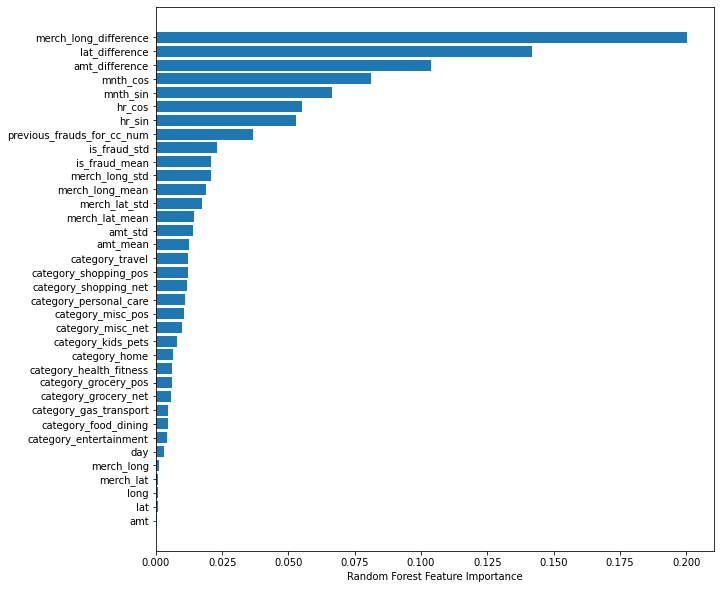

In [ ]:
# Running random forest to get feature importances.

rf.feature_importances_
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train_scaled_df.columns)
feature_importances.to_csv(folder_location + "RF_feature_importances.csv")
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X_train_scaled_df.columns, rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

[0.90412783 0.89613848 0.8828229  0.86950732 0.87083888 0.86533333
 0.88533333 0.892      0.88266667 0.89480692 0.90146471 0.88681758
 0.87882823 0.88814913 0.88548602 0.88666667 0.88666667 0.87466667
 0.87866667 0.87483356 0.87483356 0.88814913 0.87882823 0.87083888
 0.8988016  0.9        0.9        0.87466667 0.88266667 0.88548602]


In [23]:
from collections import Counter

counter = Counter(y_train_under)
print(counter)

Counter({0: 75060, 1: 7506})


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.41      0.73      0.52      2145

    accuracy                           0.99    555719
   macro avg       0.70      0.86      0.76    555719
weighted avg       1.00      0.99      1.00    555719



In [50]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def get_model_metrics(model, model_name, X_train, y_train, X_test, y_test):

  cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
  scores = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='f1', cv=cv)

  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  f1 = f1_score(y_test, predictions)
  tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

  recall = tp / (tp + fn)
  specificity = tn / (fp + tn)
  precision = tp / (tp + fp)
  accuracy = (tp + tn) / (tp + fp + tn + fn) 

  print(model_name, " model results -----------------------------------------------------------")
  print("F1 Scores Average ", sum(scores) / len(scores))
  print("F1: ", f1)
  print("Recall: ", recall)
  print("Specificity: ", specificity)
  print("Precision: ", precision)
  print("Accuracy: ", accuracy)
  print(confusion_matrix(y_test, predictions))



In [53]:
# Testing adaboost classifier with undersampled, oversampled, and normal training to get best sampling method
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# No sampling
adaboost = AdaBoostClassifier()
get_model_metrics(adaboost, "AdaBoost with no sampling", X_train_scaled_df.tail(20000), y_train.tail(20000).values.ravel(), X_test_scaled_df.head(20000), y_test.head(20000))

# UnderSampling
undersample = RandomUnderSampler(sampling_strategy = 0.1)
X_train_under, y_train_under = undersample.fit_resample(X_train_scaled_df, y_train)
get_model_metrics(adaboost, "AdaBoost with undersampling", X_train_under[-20000:], y_train_under[-20000:].ravel(), X_test_scaled_df.head(20000), y_test.head(20000))

# Oversampling
over = SMOTE(sampling_strategy = 0.1)
X_train_over, y_train_over = over.fit_resample(X_train_scaled_df, y_train)
get_model_metrics(adaboost, "AdaBoost with oversampling", X_train_over[-20000:], y_train_over[-20000:].ravel(), X_test_scaled_df.head(20000), y_test.head(20000))

# OverSampling plus undersampling
undersample = RandomUnderSampler(sampling_strategy = 0.1)
X_train_over_under, y_train_over_under = undersample.fit_resample(X_train_over, y_train_over)
get_model_metrics(adaboost, "AdaBoost with under and oversampling", X_train_over_under[-20000:], y_train_over_under[-20000:].ravel(), X_test_scaled_df.head(20000), y_test.head(20000))



AdaBoost with no sampling  model results -----------------------------------------------------------
F1 Scores Average  0.6986657650058096
F1:  0.13902439024390245
Recall:  0.8382352941176471
Specificity:  0.9651314469195263
Precision:  0.07579787234042554
Accuracy:  0.9647
[[19237   695]
 [   11    57]]
AdaBoost with undersampling  model results -----------------------------------------------------------
F1 Scores Average  0.9763531843000203
F1:  0.04130162703379224
Recall:  0.9705882352941176
Specificity:  0.8463776841260285
Precision:  0.021099744245524295
Accuracy:  0.8468
[[16870  3062]
 [    2    66]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost with oversampling  model results -----------------------------------------------------------
F1 Scores Average  1.0
F1:  0.006776958341638428
Recall:  1.0
Specificity:  0.0
Precision:  0.0034
Accuracy:  0.0034
[[    0 19932]
 [    0    68]]
AdaBoost with under and oversampling  model results -----------------------------------------------------------
F1 Scores Average  1.0
F1:  0.006776958341638428
Recall:  1.0
Specificity:  0.0
Precision:  0.0034
Accuracy:  0.0034
[[    0 19932]
 [    0    68]]
AdaBoost with no sampling  model results -----------------------------------------------------------
F1 Scores Average  0.6986657650058096
F1:  0.13902439024390245
Recall:  0.8382352941176471
Specificity:  0.9651314469195263
Precision:  0.07579787234042554
Accuracy:  0.9647
[[19237   695]
 [   11    57]]


KeyboardInterrupt: ignored

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars


Results for LogReg -------------------------------------------------------------------
[[29870     0]
 [  118    12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29870
           1       1.00      0.09      0.17       130

    accuracy                           1.00     30000
   macro avg       1.00      0.55      0.58     30000
weighted avg       1.00      1.00      0.99     30000

F1:  0.16901408450704225
Recall:  0.09230769230769231
Specificity:  1.0
Precision:  1.0
Accuracy:  0.9960666666666667
Error:  0.003933333333333344
Results for Random Forest -------------------------------------------------------------------
[[28186  1684]
 [   40    90]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29870
           1       0.05      0.69      0.09       130

    accuracy                           0.94     30000
   macro avg       0.52      0.82      0.53     30000
weighted av

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars


Results for AdaBoost -------------------------------------------------------------------
[[29796    74]
 [   53    77]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29870
           1       0.51      0.59      0.55       130

    accuracy                           1.00     30000
   macro avg       0.75      0.79      0.77     30000
weighted avg       1.00      1.00      1.00     30000

F1:  0.5480427046263346
Recall:  0.5923076923076923
Specificity:  0.9975225979243388
Precision:  0.5099337748344371
Accuracy:  0.9957666666666667
Error:  0.004233333333333311
Results for Decision Trees -------------------------------------------------------------------
[[29111   759]
 [   60    70]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     29870
           1       0.08      0.54      0.15       130

    accuracy                           0.97     30000
   macro avg       0.54      0.76 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars


Results for SVC -------------------------------------------------------------------
[[29870     0]
 [  119    11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29870
           1       1.00      0.08      0.16       130

    accuracy                           1.00     30000
   macro avg       1.00      0.54      0.58     30000
weighted avg       1.00      1.00      0.99     30000

F1:  0.15602836879432627
Recall:  0.08461538461538462
Specificity:  1.0
Precision:  1.0
Accuracy:  0.9960333333333333
Error:  0.003966666666666674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in long_scalars


Results for kNN -------------------------------------------------------------------
[[29822    48]
 [  107    23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29870
           1       0.32      0.18      0.23       130

    accuracy                           0.99     30000
   macro avg       0.66      0.59      0.61     30000
weighted avg       0.99      0.99      0.99     30000

F1:  0.2288557213930348
Recall:  0.17692307692307693
Specificity:  0.998393036491463
Precision:  0.323943661971831
Accuracy:  0.9948333333333333
Error:  0.005166666666666653
Results for Naive Bayes -------------------------------------------------------------------
[[  898 28972]
 [    2   128]]
              precision    recall  f1-score   support

           0       1.00      0.03      0.06     29870
           1       0.00      0.98      0.01       130

    accuracy                           0.03     30000
   macro avg       0.50      0.51      0.03

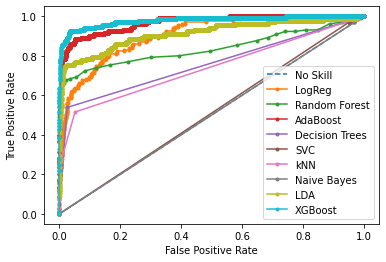

,F1-Score,F2-Score,G-Mean,Recall for 1,Precision for 1,Accuracy,Error
Model Name,,,,,,,
LogReg,0.074783,0.050283,0.128388,0.041270,NaN,0.99252,0.00748
Random Forest,0.421996,0.324060,0.515631,0.281254,0.982609,0.99468,0.00532
AdaBoost,0.387507,0.309280,0.462788,0.273559,NaN,0.99432,0.00568
Decision Trees,0.441415,0.430029,0.645417,0.432017,0.523998,0.99296,0.00704
SVC,0.107510,0.075887,0.156002,0.063492,NaN,0.99264,0.00736
kNN,0.084099,0.057651,0.161859,0.047664,NaN,0.99240,0.00760
Naive Bayes,0.359315,0.396184,0.656673,0.451714,0.343394,0.99004,0.00996
LDA,0.248197,0.221214,0.428006,0.207706,0.354114,0.99168,0.00832
XGBoost,0.468357,0.372148,0.552458,0.328311,0.892857,0.99520,0.00480


In [60]:
## Perform cross validation to get preliminary best models
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, roc_curve
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
!pip install tscv
from tscv import GapWalkForward
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def perform_cross_validation(metrics_df, model, model_name, X_training, y_training):
  tscv = GapWalkForward(n_splits=5, gap_size=0, test_size=5000)

  g_means = []
  f1s = []
  f2s = []
  precisions = []
  recalls = []
  accuracies = []
  errors = []

  for train_index, test_index in tscv.split(X_training):
    if model_name == "XG_Boost":
      X_train, X_test = X_training.iloc[train_index], X_training.iloc[test_index]
      y_train, y_test = y_training.iloc[train_index], y_training.iloc[test_index]

      # XGB Classifier
      eval_set = [(X_train, y_train), (X_test, y_test)]

      # Fit the classifier to the training set
      model.fit(X_train, y_train, eval_metric=["aucpr"], eval_set=eval_set, verbose=True)
      results = model.evals_result()

      # Predict the labels of the test set: preds
      predictions = model.predict(X_test)

    else:
      X_train, X_test = X_training.iloc[train_index], X_training.iloc[test_index]
      y_train, y_test = y_training.iloc[train_index], y_training.iloc[test_index]

      model.fit(X_train, y_train.values.ravel())
      predictions = model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    f2 = fbeta_score(y_test, predictions, beta=2)

    # print(confusion_matrix(y_test, predictions))
    # print(classification_report(y_test, predictions))

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    recall = tp / (tp + fn)
    specificity = tn / (fp + tn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    g_mean = np.sqrt(recall * specificity)

    f1s.append(f1)
    f2s.append(f2)
    g_means.append(g_mean)
    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    errors.append(1- accuracy)
  
  metrics_df.loc[model_name] = [np.mean(f1s), np.mean(f2s), np.mean(g_means), np.mean(recalls), np.mean(precisions), np.mean(accuracies), np.mean(errors)]

  return model, metrics_df

def compare_models(models, model_names, X_training, y_training, X_testing, y_testing):
  cross_validation_model_scores = pd.DataFrame(data=None, columns = ["Model Name", "F1-Score", "F2-Score", "G-Mean", "Recall for 1", "Precision for 1", "Accuracy", "Error"])
  cross_validation_model_scores.set_index('Model Name', inplace=True)
  # plot no skill roc curve
  plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
  for i in range(len(models)):
    model, cross_validation_model_scores = perform_cross_validation(cross_validation_model_scores, models[i], model_names[i], X_training, y_training)
    predictions = model.predict(X_testing)
    print("Results for " + model_names[i] + " -------------------------------------------------------------------")
    print(confusion_matrix(y_testing, predictions))
    print(classification_report(y_testing, predictions))
    f1 = f1_score(y_testing, predictions)
    tn, fp, fn, tp = confusion_matrix(y_testing, predictions).ravel()

    recall = tp / (tp + fn)
    specificity = tn / (fp + tn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    error = 1 - accuracy
    print("F1: ", f1)
    print("Recall: ", recall)
    print("Specificity: ", specificity)
    print("Precision: ", precision)
    print("Accuracy: ", accuracy)
    print("Error: ", error)

    get_precision_recall_curve(model, model_names[i], X_testing, y_testing)

  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  return cross_validation_model_scores

def get_precision_recall_curve(model, model_name, x_test, y_test):
  # predict probabilities
  yhat = model.predict_proba(x_test)
  # retrieve just the probabilities for the positive class
  pos_probs = yhat[:, 1]

  # calculate roc curve for model
  fpr, tpr, _ = roc_curve(y_test, pos_probs)
  # plot model roc curve
  plt.plot(fpr, tpr, marker='.', label=model_name)
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')


all_models = [LogisticRegression(), RandomForestClassifier(), AdaBoostClassifier(), DecisionTreeClassifier(), SVC(probability=True), KNeighborsClassifier(), GaussianNB(), LinearDiscriminantAnalysis(), xgb.XGBClassifier()]
all_model_names = ["LogReg", "Random Forest", "AdaBoost", "Decision Trees", "SVC", "kNN", "Naive Bayes", "LDA", "XGBoost"]

compare_models(all_models, all_model_names, X_train_scaled_df.tail(50000), y_train.tail(50000), X_test_scaled_df.head(30000), y_test.head(30000))

In [71]:
from sklearn.model_selection import GridSearchCV

def cross_validation_hyperparameter_tuning(model_name, model, param_grid, X_train, y_train, X_test, y_test):
  tscv = GapWalkForward(n_splits=5, gap_size=0, test_size=1000)
  print(tscv)
  clf = GridSearchCV(model, param_grid=param_grid, scoring="f1", cv = tscv)
  clf.fit(X_train, y_train)
  print("Best model params for: ", model_name)
  print(clf.best_params_)

  # find best model score
  print(clf.score(X_train, y_train))
  
  predictions = clf.predict(X_train)
  print(classification_report(predictions, y_train))
  print(confusion_matrix(predictions, y_train))

  # find best model score
  print(clf.score(X_test, y_test))
  
  predictions = clf.predict(X_test)
  print(classification_report(predictions, y_test))
  print(confusion_matrix(predictions, y_test))

In [78]:
# Perform hyperparameter tuning for XGBoost
# Performed multiple grid searches each time to reduce the run time instead of running all params at once, used some recommended default values for more specific parameters

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

param_test4 = {
 'learning_rate':[.001, .01, .05, .1, .2, .5, 1]
}

param_test5 = {
 'n_estimators':[10, 50, 100, 150, 250]
}

cross_validation_hyperparameter_tuning("XGBoost", xgb.XGBClassifier( learning_rate = 0.1, max_depth=3, 
 min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', scale_pos_weight=1, seed=27), param_test5, X_train_scaled_df.tail(20000), y_train.tail(20000).values.ravel(), X_test_scaled_df.head(10000), y_test.head(10000).values.ravel())


GapWalkForward(gap_size=0, max_train_size=None, n_splits=5, rollback_size=0,
        test_size=1000)
Best model params for:  XGBoost
{'n_estimators': 150}
0.9123867069486404
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19849
           1       0.84      1.00      0.91       151

    accuracy                           1.00     20000
   macro avg       0.92      1.00      0.96     20000
weighted avg       1.00      1.00      1.00     20000

[[19820    29]
 [    0   151]]
0.5098039215686274
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9971
           1       0.59      0.45      0.51        29

    accuracy                           1.00     10000
   macro avg       0.79      0.72      0.75     10000
weighted avg       1.00      1.00      1.00     10000

[[9962    9]
 [  16   13]]


In [ ]:
# Training xgboost given ideal parameters
xgb_tuned = xgb.XGBClassifier(learning_rate = 0.1, n_estimators=150, max_depth=3, min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=0.6, objective= 'binary:logistic', scale_pos_weight=1)
xgb_untuned = xgb.XGBClassifier()

def get_train_and_test_final_metrics(models, model_names, X_train, y_train, X_test, y_test):
  metrics_df = pd.DataFrame(columns = ["Model_Name", "Testing F1", "Training F1", "Recall", "Precision", "Accuracy", "TP", "FP", "TN", "FN"])

  for i in range(len(models)):
    model = models[i]
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    f1_training = f1_score(y_train, predictions_train)
    f1_testing = f1_score(y_test, predictions_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    metrics_df[i] = [model_name, f1_testing, f1_training, recall, precision, accuracy, tp, fp, tn, fn]
  
  return metrics_df

metrics = get_train_and_test_final_metrics([xgb_tuned, xgb_untuned], ["Tuned XGBoost", "Untuned XGBoost"], X_train_scaled_df.tail(500000), y_train.tail(500000).values.ravel(), X_test_scaled_df.head(100000), y_test.head(100000).values.ravel())



Best Params for XGBoost:
*   max_depth = 3
*   n_estimators = 150
*   min_child_weight = 3
*   gamma = .2
*   subsample = 3
*   colsample_bytree = 3
*   learning_rate = 0.1




In [ ]:
print(metrics)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-aucpr:0.229208	validation_1-aucpr:0.089536
[1]	validation_0-aucpr:0.404353	validation_1-aucpr:0.193185
[2]	validation_0-aucpr:0.411764	validation_1-aucpr:0.20682
[3]	validation_0-aucpr:0.410199	validation_1-aucpr:0.196935
[4]	validation_0-aucpr:0.413532	validation_1-aucpr:0.208561
[5]	validation_0-aucpr:0.429582	validation_1-aucpr:0.214611
[6]	validation_0-aucpr:0.429679	validation_1-aucpr:0.214645
[7]	validation_0-aucpr:0.439594	validation_1-aucpr:0.228769
[8]	validation_0-aucpr:0.452492	validation_1-aucpr:0.237754
[9]	validation_0-aucpr:0.469782	validation_1-aucpr:0.235728
[10]	validation_0-aucpr:0.494535	validation_1-aucpr:0.256122
[11]	validation_0-aucpr:0.504627	validation_1-aucpr:0.264186
[12]	validation_0-aucpr:0.505031	validation_1-aucpr:0.262181
[13]	validation_0-aucpr:0.506889	validation_1-aucpr:0.265664
[14]	validation_0-aucpr:0.506949	validation_1-aucpr:0.265985
[15]	validation_0-aucpr:0.547526	validation_1-aucpr:0.305617
[16]	validation_0-aucpr:0.549321	va

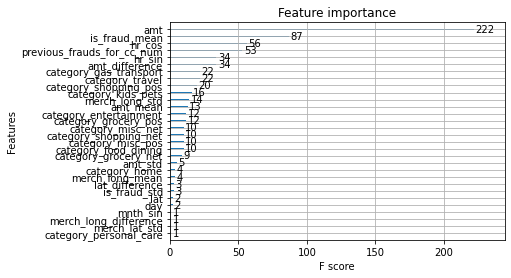

In [ ]:
def train_xgb(model, X_train, y_train, X_test, y_test):

  # XGB Classifier
  eval_set = [(X_train, y_train), (X_test, y_test)]

  # Fit the classifier to the training set
  model.fit(X_train, y_train, eval_metric=["aucpr"], eval_set=eval_set, verbose=True)
  results = model.evals_result()

  # Predict the labels of the test set: preds
  predictions = model.predict(X_test)

  xgb.plot_importance(model)

  return model

model = train_xgb(xgb.XGBClassifier(objective='binary:logistic', seed=123, scale_pos_weight=172), X_train_scaled_df, y_train, X_test_scaled_df, y_test)

predictions = model.predict(X_test_scaled_df)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
f1 = f1_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

recall = tp / (tp + fn)
specificity = tn / (fp + tn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn)
error = 1 - accuracy
print("F1: ", f1)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Precision: ", precision)
print("Accuracy: ", accuracy)
print("Error: ", error)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC score for undersampled data:  0.5640515583681343


[[49674   127]
 [  173    26]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49801
           1       0.17      0.13      0.15       199

    accuracy                           0.99     50000
   macro avg       0.58      0.56      0.57     50000
weighted avg       0.99      0.99      0.99     50000

--------------------------------------------------------
[[47094  2458]
 [    0   448]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     49552
           1       0.15      1.00      0.27       448

    accuracy                           0.95     50000
   macro avg       0.58      0.98      0.62     50000
weighted avg       0.99      0.95      0.97     50000



              precision    recall  f1-score   support

           0       1.00      0.97      0.98     55381
           1       0.07      0.78      0.13       191

    accuracy                           0.97     55572
   macro avg       0.54      0.87      0.56     55572
weighted avg       1.00      0.97      0.98     55572

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     75060
           1       0.93      0.88      0.91      7506

    accuracy                           0.98     82566
   macro avg       0.96      0.94      0.95     82566
weighted avg       0.98      0.98      0.98     82566



[[53490  1891]
 [   42   149]]
